### Signal Modelling - 2

Author : Arun Prakash A, arunprakash.ece@kongu.ac.in <br>

 * Pade approximation is good for the interval (0,p+q). However, it provides no clue about the approximated values after the interval.
 * In this notebook, we implement the **Prony's Method** for model parameter estimation.


In [1]:
import numpy as np
from scipy import linalg as lalg
from scipy import signal as sig
from matplotlib import pyplot as plt

 * $ x(n), \ n=0,1,2,...,N-1$
 * Normal Equation : $$ \sum_{l=1}^{p}a_p(l)r_x(k,l)=-r_x(k,0) \ \ \ \ \text{(eq.1)}$$ where, $k=1,..,p$.
  $$ r_x(k,l) = \sum_{n=q+1}^{\infty} x(n-l)x(n-k),\text{where} N \to \infty$$
 
 * When, say, $q=0$, the index $n$ starts from 1 and slides upto $x[1-p]$.Therefore, if $p>1$ the index becomes negative.We restrict $q < p$ and $p+q < N$, where $N$ is the length of the sequence padded with zeros.
 
 * As we increase the value of $q>0$, and if $q+1 < p$, then $p-(q+1)$ zeros have to be padded with x(n). Since $p>q$ always, we append $p-1$ zeros at both the ends of the sequence.
 

In [2]:
N = 5
p = 3
q = 1
x = np.ones(N)

**Implementing Left side of Eq.1**

In [3]:
def corr(x,p,q):
    xpad = np.concatenate((np.zeros(p-1),x,np.zeros(p-1)))
    Q = (q+1)+(p-1)  # q+1 in the equation changes to q+p-1 due to padding
    temp = []
    for n in range(Q,len(xpad)):  
        #print(n,n-p-1)
        temp.append(xpad[n:(n-p-1):-1]) # elements are taken in a reverse order    
    Xq = np.vstack(temp)
    rx_1p = np.matmul(Xq.T,Xq) 
    return (Xq,rx_1p)

In [4]:
(xq,rx) = corr(x,p,q)

**Obtaining right side correlation matrix of Eq.1**
 $$ r_x(k,0) = \sum_{n=q+1}^{\infty} x(n)x(n-k),\text{where} N \to \infty$$
 
 * We need not to recompute this again,we set $l=0$ instead of $l=1$ for $x(n-l)$ in the above function definition to obtain the augmented correlation matrix. Therefore, the first column in the matrix is the correlation vector of $r_x(k,0)$.
 * Rememeber $r_x(k,0)$ is a column vector of shape $p \times 1$ as $ k \in \{1,2,..p\}$

In [5]:
rx_left = rx[1:,1:]
rx_right = rx[1:,0]
print('The data matrix Xq: \n \n',xq)
print('\n The augmented correlation matrix: \n \n',rx)
print('\n The left correlation matrix rx(k,l): \n \n',rx_left)
print('\n The right correlation vector rx(k,0) : \n \n',rx_right)      

The data matrix Xq: 
 
 [[1. 1. 1. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]]

 The augmented correlation matrix: 
 
 [[3. 3. 3. 2.]
 [3. 4. 4. 3.]
 [3. 4. 5. 4.]
 [2. 3. 4. 4.]]

 The left correlation matrix rx(k,l): 
 
 [[4. 4. 3.]
 [4. 5. 4.]
 [3. 4. 4.]]

 The right correlation vector rx(k,0) : 
 
 [3. 3. 2.]


**obtaining the Denominator coefficients**

In [6]:
inv = lalg.pinv(rx_left)
ap_k = np.matmul(inv,-1*rx_right)
den_coef = np.insert(ap_k,0,1)

**obtaining Numerator coefficient**

In [7]:
bn = np.convolve(x,den_coef)
num_coef = bn[0:q+1] 

In [8]:
def prony(x,p,q):  
    
    (xq,rx) = corr(x,p,q)
    rx_left = rx[1:,1:]
    rx_right = rx[1:,0]
    inv = lalg.pinv(rx_left)
    ap_k = np.matmul(inv,-1*rx_right)
    den_coef = np.insert(ap_k,0,1)
    bn = np.convolve(x,den_coef)
    num_coef = bn[0:q+1] 
    impulse = np.zeros(100)
    impulse[0]=1
    yn = sig.lfilter(num_coef,den_coef,impulse)
    
    return yn,rx,den_coef

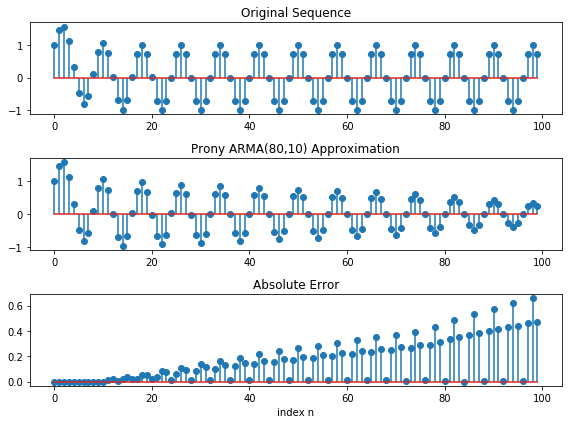

In [9]:
n = np.arange(100)
x = np.sin(0.25*np.pi*n)+(0.75)**n
yn,rx,den_coef = prony(x,p=80,q=10)
fig,ax = plt.subplots(3,1,figsize=(8,6))
ax[0].stem(x,use_line_collection=True)
ax[1].stem(yn,use_line_collection=True)
ax[2].stem(np.abs(yn-x),use_line_collection=True)
ax[0].set_title('Original Sequence')
ax[1].set_title('Prony ARMA(80,10) Approximation')
ax[2].set_title('Absolute Error')
ax[2].set_xlabel('index n')
fig.tight_layout()

In [12]:
q=10
error = []
for p in range (10,80):
    yn,_,_ = prony(x,p,q)
    error.append(np.sum(np.square(np.abs(yn[q+1:]-x[q+1:]))))
q = np.arange(10,80)

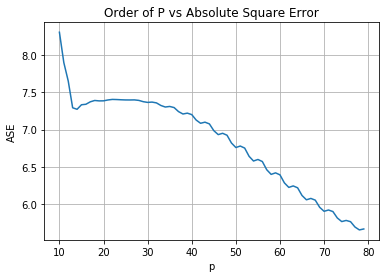

In [13]:
plt.plot(q,error)
plt.xlabel('p')
plt.ylabel('ASE')
plt.title('Order of P vs Absolute Square Error')
plt.grid()
plt.show()

* Recall that the **Prony method** gives zero error over the interval $0 \to q$ (because, numerator coefficients  $b_q(n)$ are found by setting $e(n)=a_p(n)*x(n)-b_q(n) = 0, \therefore,b_q(n)=a_p(n)*x(n)$) 
* Minimizes Absolute square error for samples considered after $n=q+1$, that is,  $x(n), \text{for} n \in \{q+1,..,\infty\}$  
* It also provides the bound on the error for the given order $p$.

$$ \zeta_{p,q} = r_x(0,0)+\sum_{k=1}^{p}a_p(k)r_x(0,k)$$

In [14]:
# for q=10,p=80
np.sum(rx[0,:]*den_coef)

0.48293619856187636

**SHanks Method**

 * We know that the numerator coefficients  $b_q(n)$ are found by setting $e(n)=a_p(n)*x(n)-b_q(n) = 0, \therefore,b_q(n)=a_p(n)*x(n)$, **is there any other way?**